In [1]:
import os
import re
import math
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import kaleido
import ipywidgets as widgets
from plotly.subplots import make_subplots
from IPython.display import display, Image

# Statistical analysis
from scipy.stats import boxcox, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ML libraries and utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Hyperparameter tuning
import xgboost as xgb
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Data Overview

In [2]:
stock_tickers = ['DNUT', 'MCD', 'DPZ', 'PZZA', 'SBUX', 'WEN', 'YUM']

# Dictionary to store the dataframes, with stock tickers as keys
stock_data = {}

for ticker in stock_tickers:
    file_path = os.path.join('data/', f'{ticker}.csv')
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayName'] = df['Date'].dt.day_name()
    stock_data[ticker] = df
    
    print(f'{ticker} data:')
    print(stock_data[ticker].head())
    print()

DNUT data:
        Date       Open       High    Low      Close  Adj Close    Volume  \
0 2021-07-01  16.299999  21.690001  15.50  21.000000  20.361467  40888200   
1 2021-07-02  19.854000  20.450001  18.32  19.120001  18.538637   8631400   
2 2021-07-06  18.900000  19.120001  17.00  17.000000  16.483095   3973000   
3 2021-07-07  17.289000  18.160000  17.00  17.780001  17.239378   3213500   
4 2021-07-08  17.250000  18.350000  17.00  18.200001  17.646606   5448300   

   DayOfWeek    DayName  
0          3   Thursday  
1          4     Friday  
2          1    Tuesday  
3          2  Wednesday  
4          3   Thursday  

MCD data:
        Date  Open      High       Low     Close  Adj Close   Volume  \
0 1966-07-05   0.0  0.273663  0.267490  0.269547   0.115991   388800   
1 1966-07-06   0.0  0.283951  0.267490  0.283951   0.122190   692550   
2 1966-07-07   0.0  0.291152  0.271605  0.273663   0.117762  1858950   
3 1966-07-08   0.0  0.276749  0.267490  0.276749   0.119090  1239300   

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6796 entries, 0 to 6795
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6796 non-null   datetime64[ns]
 1   Open       6796 non-null   float64       
 2   High       6796 non-null   float64       
 3   Low        6796 non-null   float64       
 4   Close      6796 non-null   float64       
 5   Adj Close  6796 non-null   float64       
 6   Volume     6796 non-null   int64         
 7   DayOfWeek  6796 non-null   int32         
 8   DayName    6796 non-null   object        
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(1)
memory usage: 451.4+ KB


In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'DayOfWeek', 'DayName'],
      dtype='object')

In [5]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
DayOfWeek             int32
DayName              object
dtype: object

### Time series data check and missing data analysis

Confirming dataset is time-based as the dates are unique and ordered chronologically (monotonically increasing) and there are no missing dates

In [6]:
def check_date_properties(df, ticker):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    unique_dates = df['Date'].nunique()
    total_rows = len(df)
    
    # Check if dates are in chronological order (monotonic increasing)
    date_order_correct = df['Date'].is_monotonic_increasing
    # Check for missing dates in the time range
    date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
    
    missing_dates = date_range.difference(df['Date'].unique())
    missing_dates_day_names = missing_dates.to_series().dt.day_name()
    
    print(f"\nTicker: {ticker}")
    print(f"Unique Dates: {unique_dates}, Total Rows: {total_rows}")
    print(f"Dates are in chronological order: {date_order_correct}")
    print(f"Number of missing dates: {len(missing_dates)}")
    if len(missing_dates) > 0:
        print(f"Missing Dates (first 10): {missing_dates[:10]}")
        print(f"Corresponding Day of the Week (first 10): {missing_dates_day_names[:10].tolist()}")

In [7]:
for ticker in stock_tickers:
    check_date_properties(stock_data[ticker], ticker)


Ticker: DNUT
Unique Dates: 810, Total Rows: 810
Dates are in chronological order: True
Number of missing dates: 367
Missing Dates (first 10): DatetimeIndex(['2021-07-03', '2021-07-04', '2021-07-05', '2021-07-10',
               '2021-07-11', '2021-07-17', '2021-07-18', '2021-07-24',
               '2021-07-25', '2021-07-31'],
              dtype='datetime64[ns]', freq=None)
Corresponding Day of the Week (first 10): ['Saturday', 'Sunday', 'Monday', 'Saturday', 'Sunday', 'Saturday', 'Sunday', 'Saturday', 'Sunday', 'Saturday']

Ticker: MCD
Unique Dates: 14652, Total Rows: 14652
Dates are in chronological order: True
Number of missing dates: 6610
Missing Dates (first 10): DatetimeIndex(['1966-07-09', '1966-07-10', '1966-07-16', '1966-07-17',
               '1966-07-23', '1966-07-24', '1966-07-30', '1966-07-31',
               '1966-08-06', '1966-08-07'],
              dtype='datetime64[ns]', freq=None)
Corresponding Day of the Week (first 10): ['Saturday', 'Sunday', 'Saturday', 'Sunday', 

The missing dates correspond to weekends (e.g., Saturdays and Sundays), which is typical for stock market data since stock markets are generally closed on weekends and certain holidays.As the model doesn’t require data for non-trading days, the missing dates can be ignored. 

The missing dates are expected non-trading days and a final check is done to confirm that no trading days are missing

In [8]:
def check_trading_days(df, ticker):
    # Check if dates are in chronological order and have no gaps between trading days
    date_order_correct = df['Date'].is_monotonic_increasing
    unique_dates = df['Date'].nunique()
    total_rows = len(df)
    
    print(f"\nTicker: {ticker}")
    print(f"Dates are in chronological order: {date_order_correct}")
    print(f"Total Trading Days: {total_rows}")
    print(f"Unique Dates: {unique_dates}")
    
    if date_order_correct and unique_dates == total_rows:
        print(f"All trading days are present with no missing dates.")
    else:
        print(f"Some trading days might be missing.")
        
for ticker in stock_tickers:
    df = stock_data[ticker]
    check_trading_days(df, ticker)


Ticker: DNUT
Dates are in chronological order: True
Total Trading Days: 810
Unique Dates: 810
All trading days are present with no missing dates.

Ticker: MCD
Dates are in chronological order: True
Total Trading Days: 14652
Unique Dates: 14652
All trading days are present with no missing dates.

Ticker: DPZ
Dates are in chronological order: True
Total Trading Days: 5083
Unique Dates: 5083
All trading days are present with no missing dates.

Ticker: PZZA
Dates are in chronological order: True
Total Trading Days: 7878
Unique Dates: 7878
All trading days are present with no missing dates.

Ticker: SBUX
Dates are in chronological order: True
Total Trading Days: 8117
Unique Dates: 8117
All trading days are present with no missing dates.

Ticker: WEN
Dates are in chronological order: True
Total Trading Days: 11187
Unique Dates: 11187
All trading days are present with no missing dates.

Ticker: YUM
Dates are in chronological order: True
Total Trading Days: 6796
Unique Dates: 6796
All trading

## Feature Distribution and Univariate Analysis

In [9]:
def summary_statistics_numerical_features(df, ticker):
    numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df_copy = df[numerical_features].copy()
    print(f"\nSummary Statistics for {ticker}:")
    
    print(df_copy.describe())  # count, mean, std, min, 25%, 50%, 75%, max
    print("-" * 50)

In [10]:
for ticker in stock_tickers:
    summary_statistics_numerical_features(stock_data[ticker], ticker)


Summary Statistics for DNUT:
             Open        High         Low       Close   Adj Close  \
count  810.000000  810.000000  810.000000  810.000000  810.000000   
mean    13.720642   13.993102   13.467714   13.719858   13.486431   
std      1.700281    1.795572    1.630926    1.707906    1.611185   
min      9.510000    9.770000    9.180000    9.200000    9.200000   
25%     12.645000   12.891250   12.430000   12.670000   12.494866   
50%     13.855000   14.095000   13.570000   13.855000   13.565939   
75%     14.820000   15.060000   14.520000   14.807500   14.534018   
max     19.854000   21.690001   18.430000   21.000000   20.361467   

             Volume  
count  8.100000e+02  
mean   1.385002e+06  
std    2.429015e+06  
min    2.011000e+05  
25%    6.872000e+05  
50%    9.469500e+05  
75%    1.462775e+06  
max    4.360570e+07  
--------------------------------------------------

Summary Statistics for MCD:
               Open          High           Low         Close     Adj 

In [11]:
def plot_numerical_features(df, ticker):
    numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(numerical_features):
        sns.histplot(df[feature], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f"{feature} for {ticker}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

Feature Distributions for DNUT


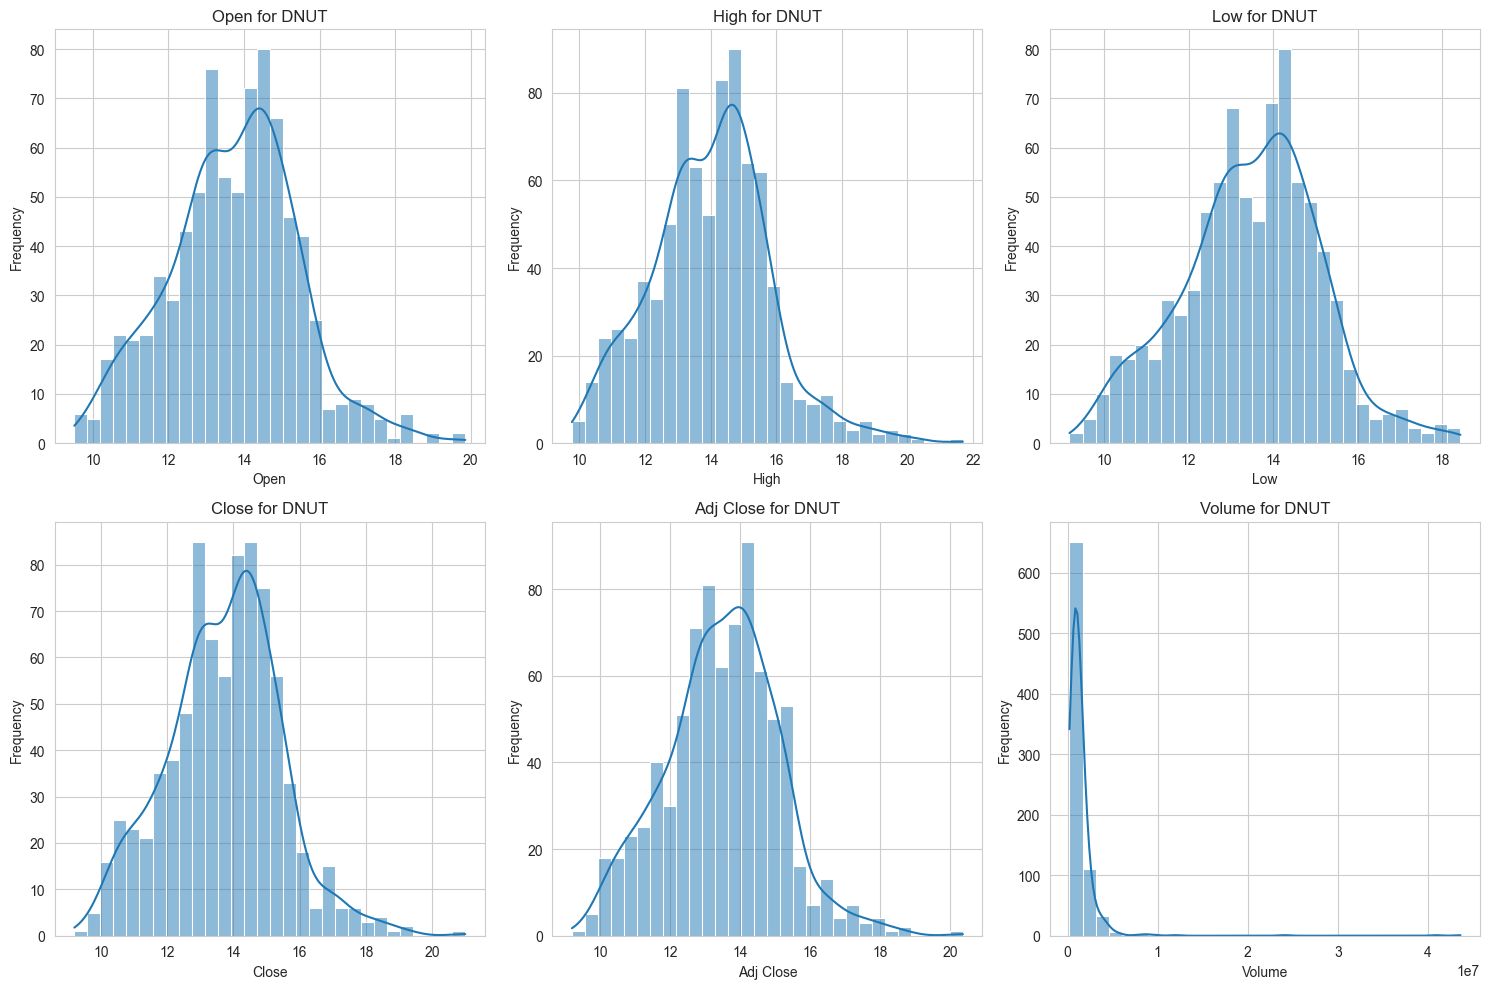

Feature Distributions for MCD


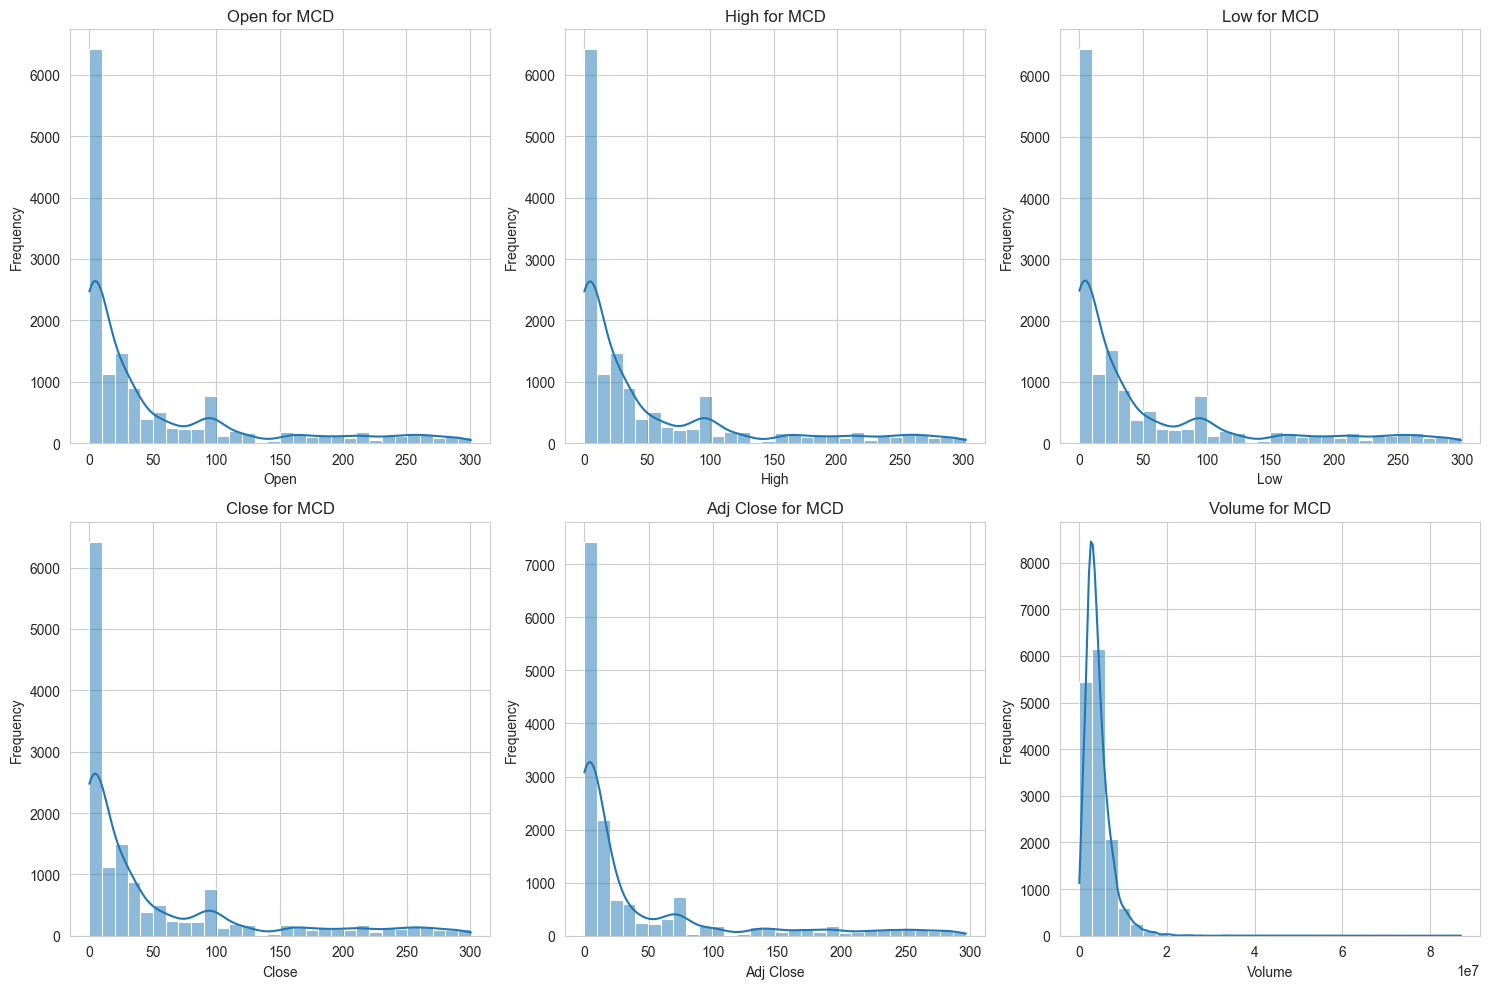

Feature Distributions for DPZ


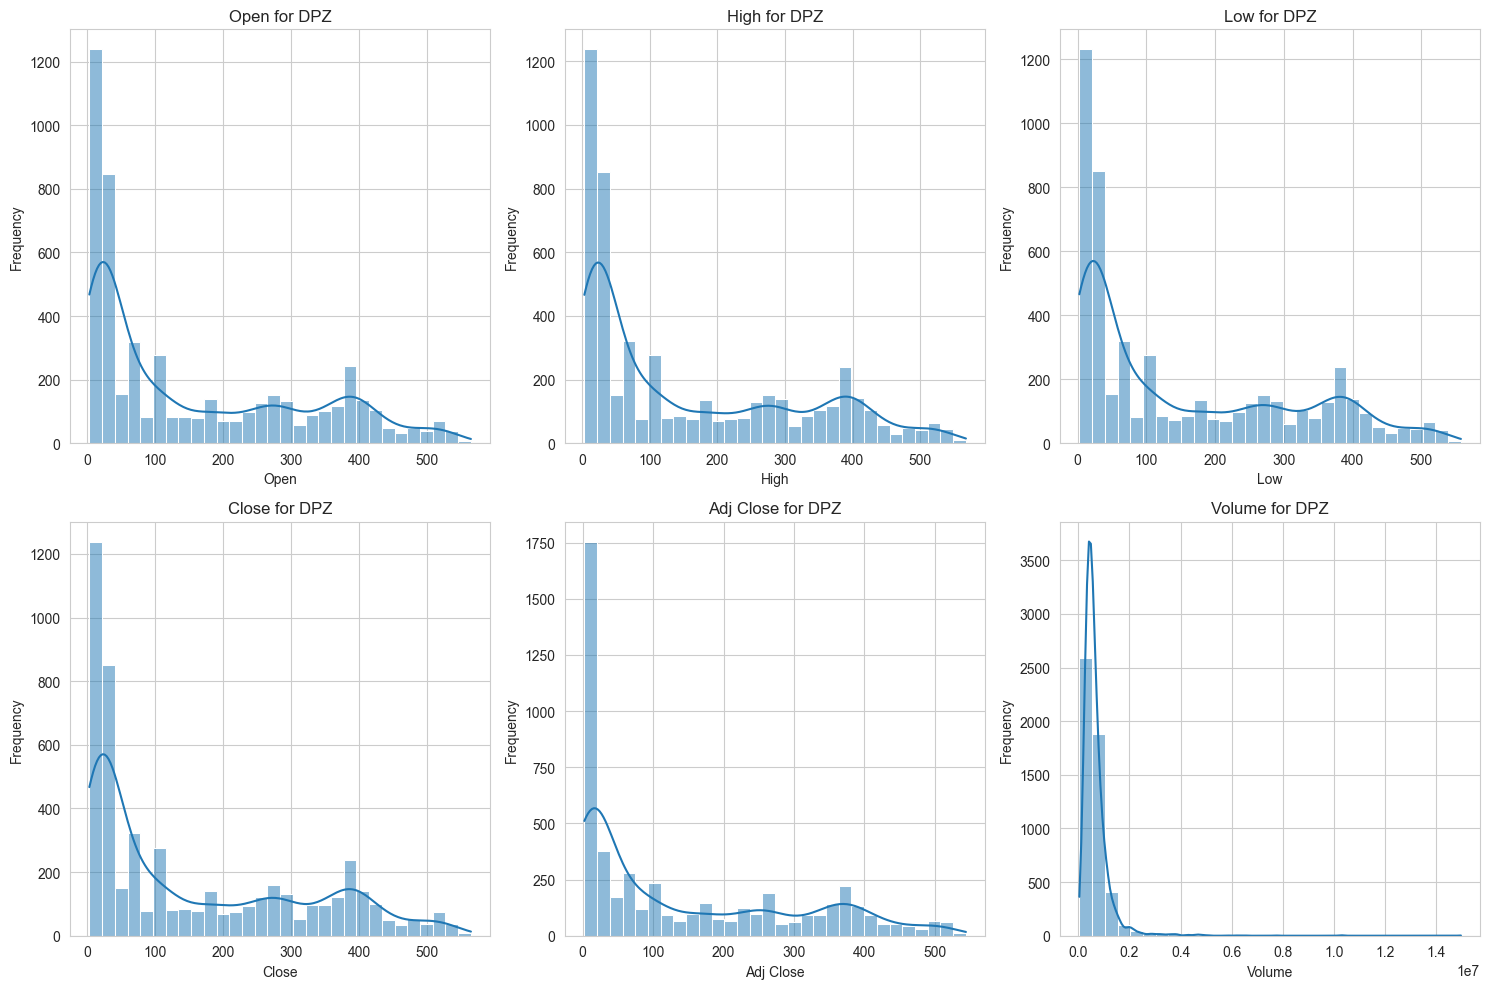

Feature Distributions for PZZA


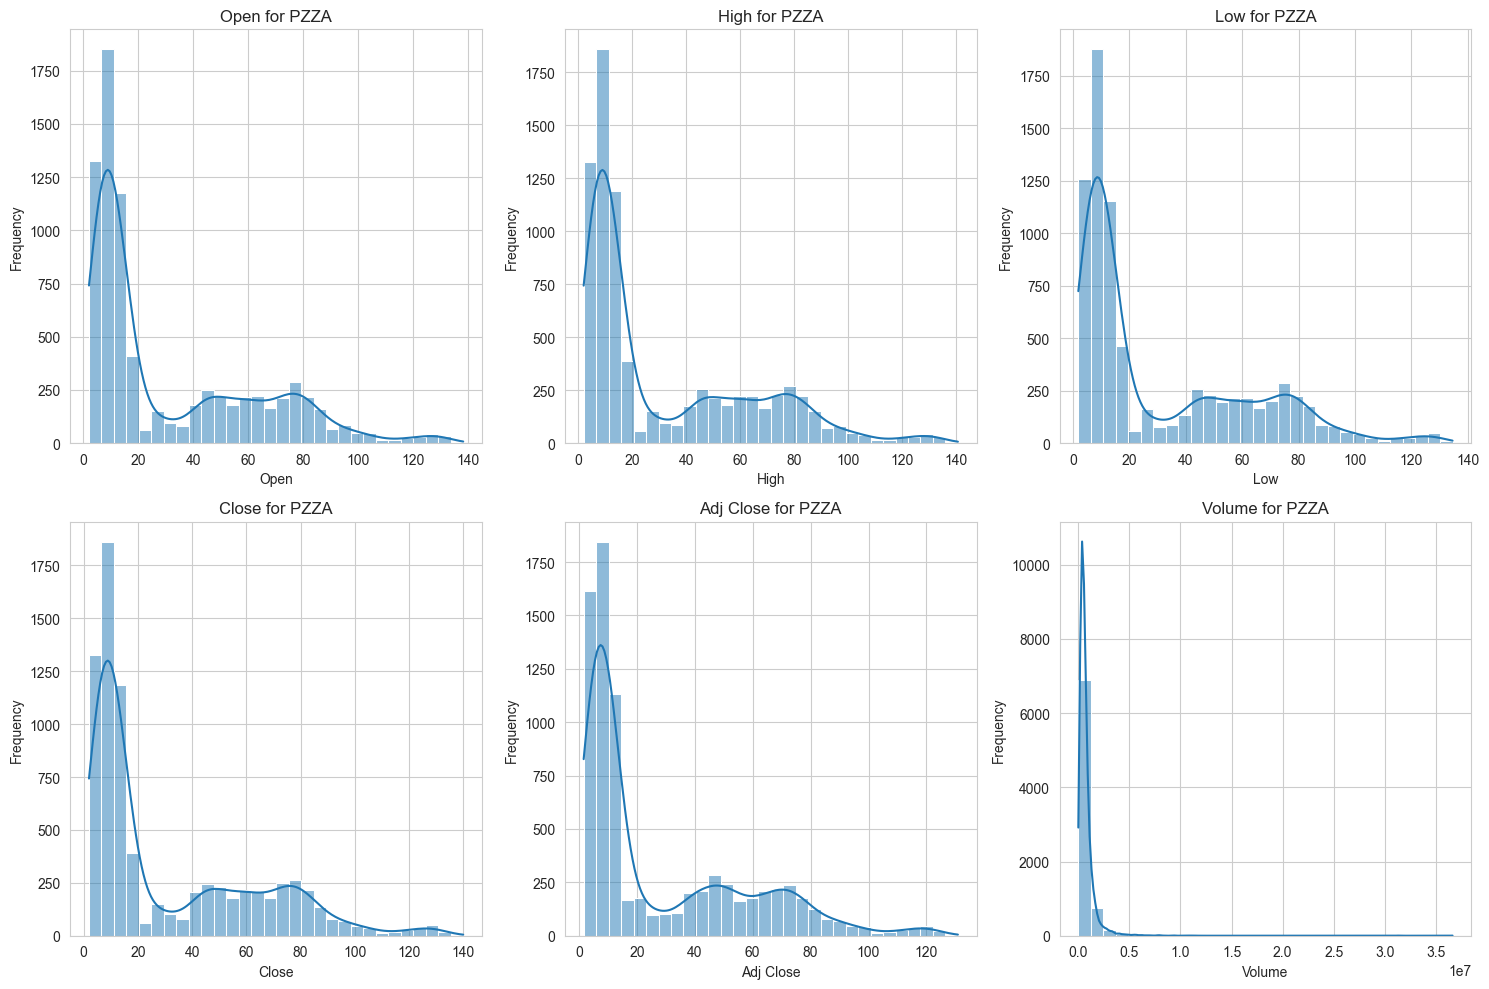

Feature Distributions for SBUX


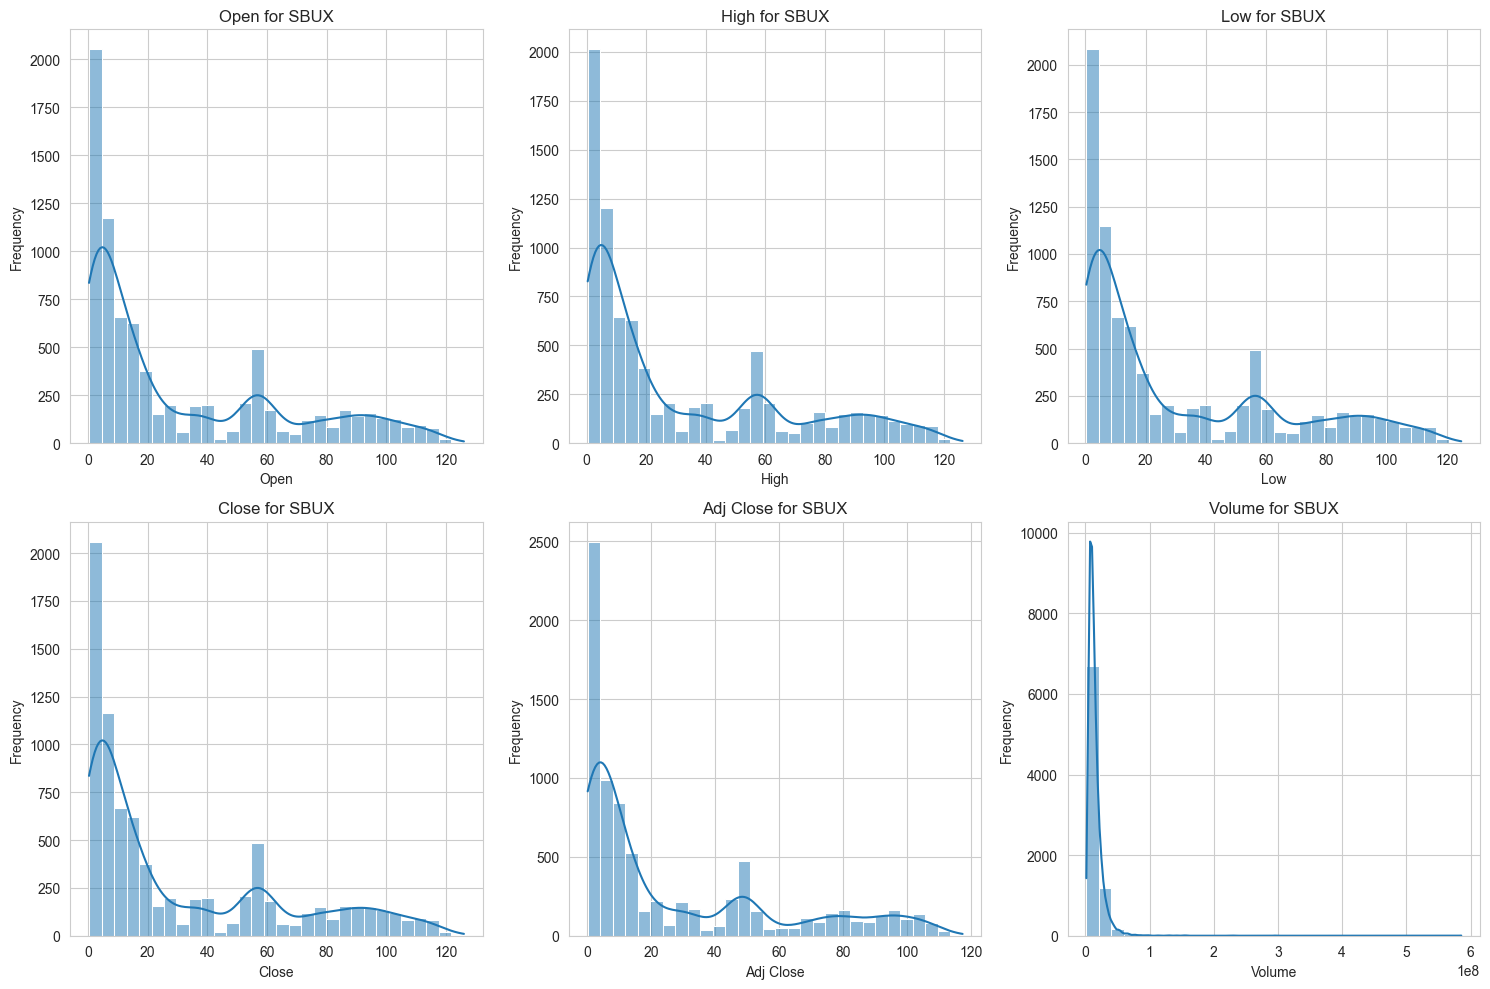

Feature Distributions for WEN


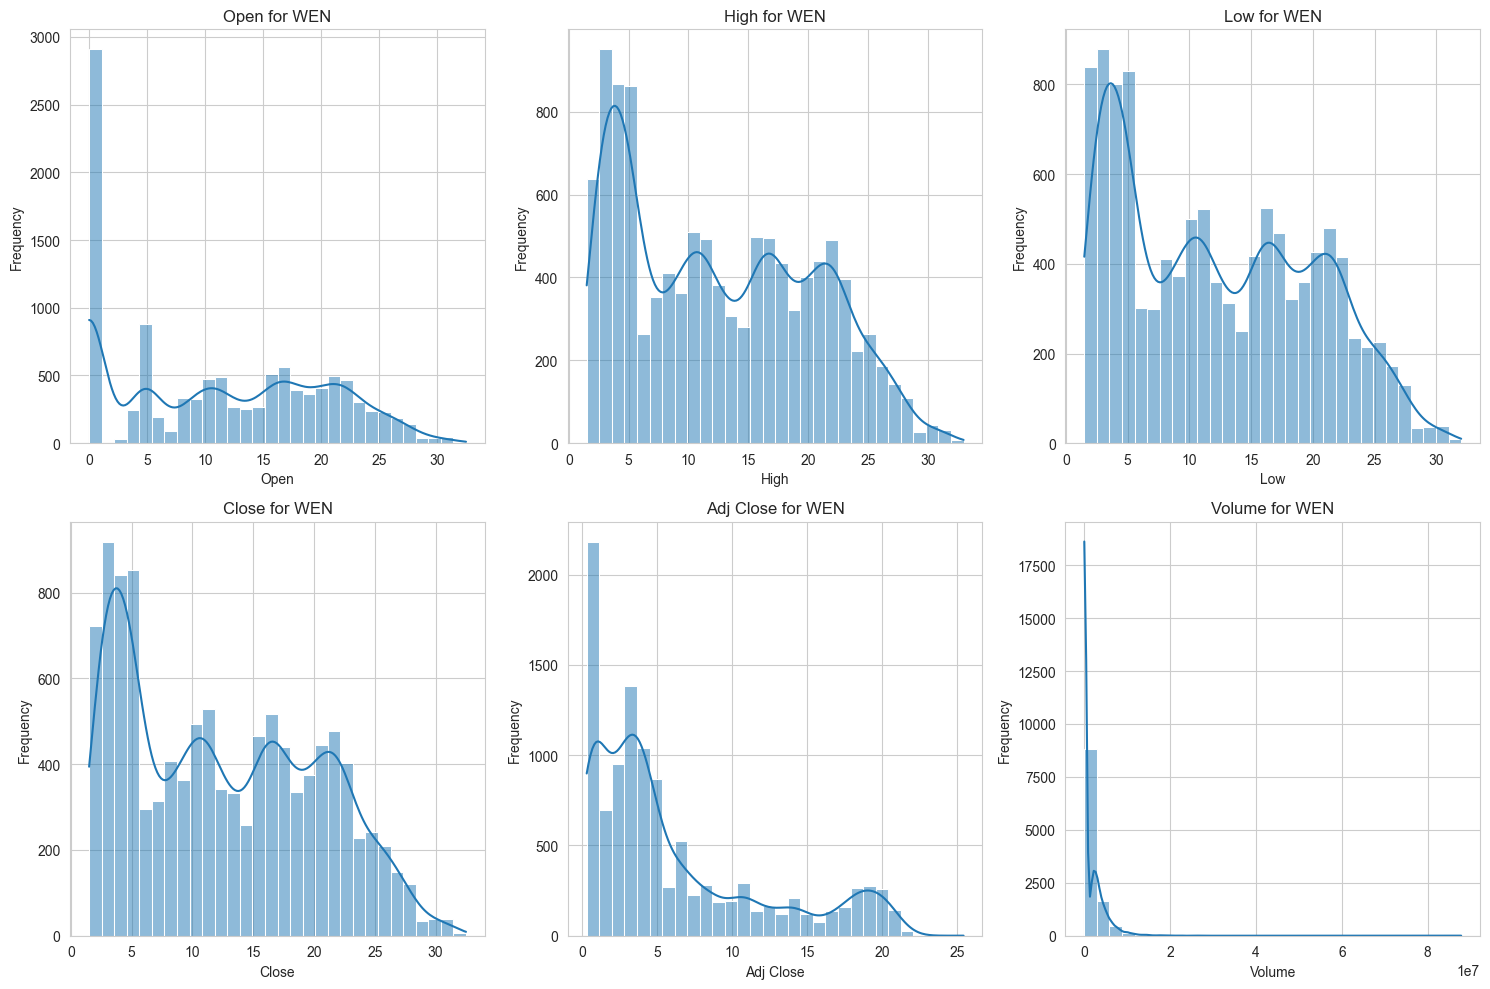

Feature Distributions for YUM


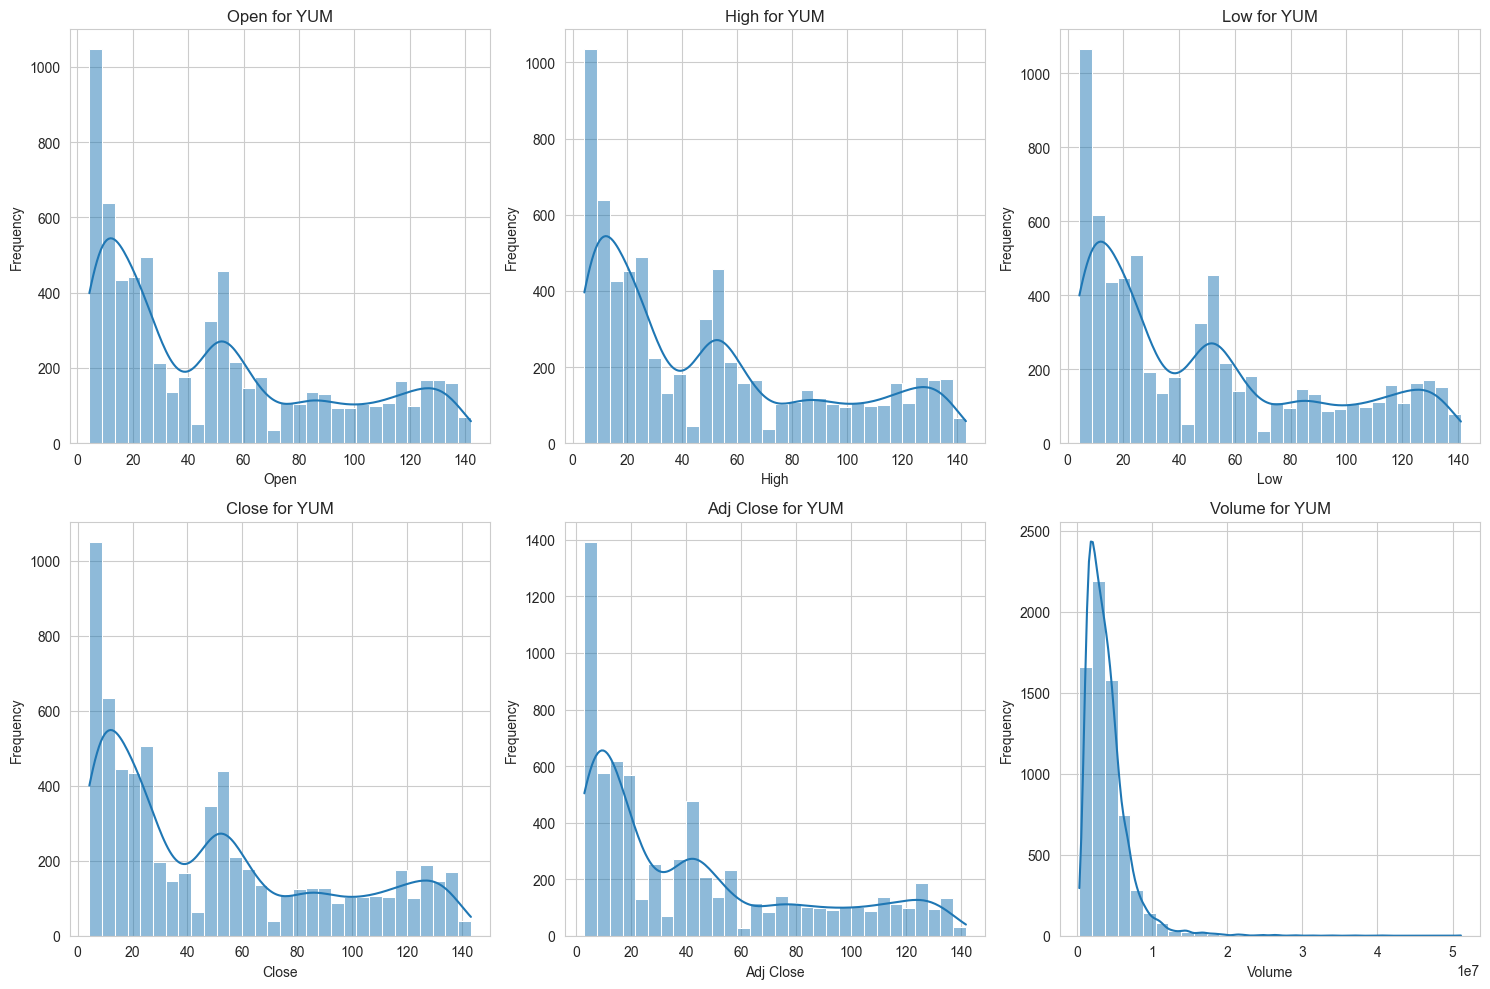

In [12]:
for ticker in stock_tickers:
    print(f"Feature Distributions for {ticker}")
    plot_numerical_features(stock_data[ticker], ticker)

## Time Series Data Analysis

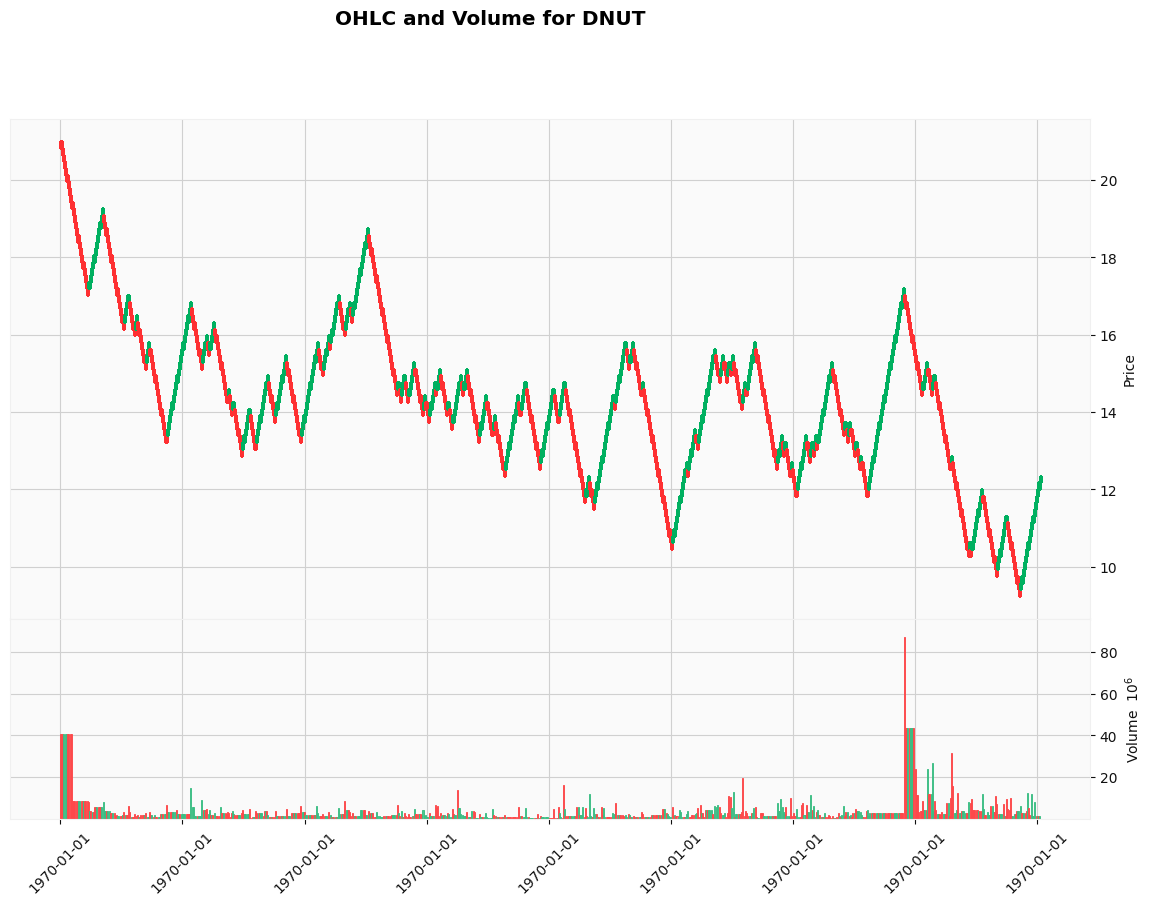

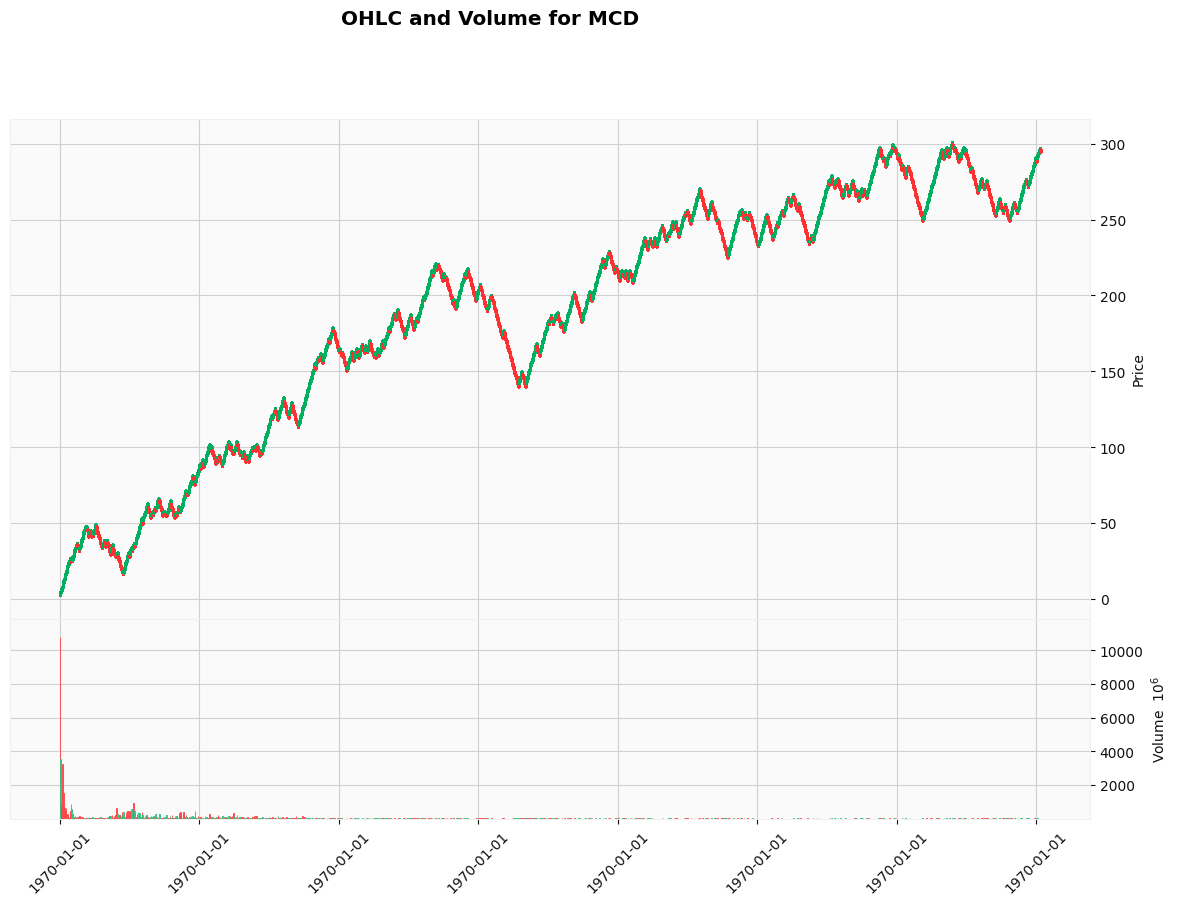

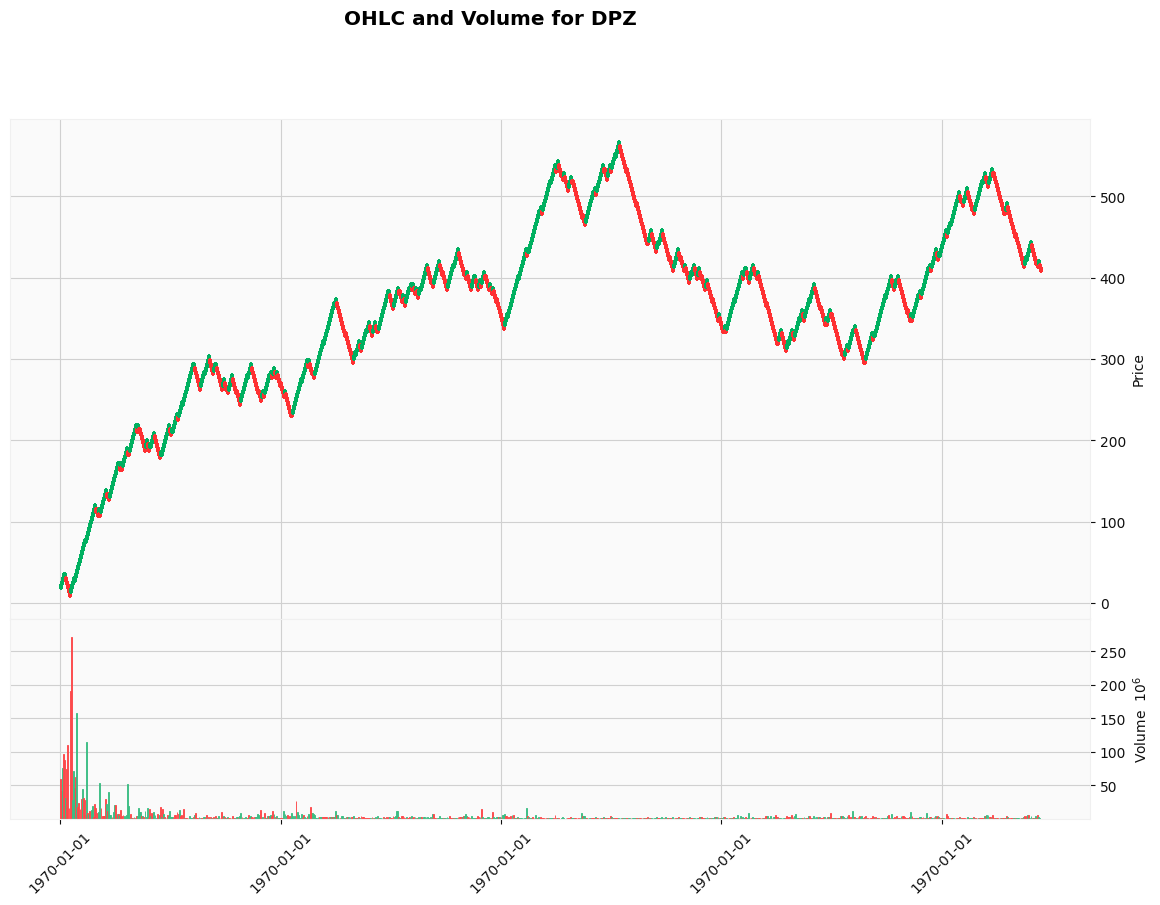

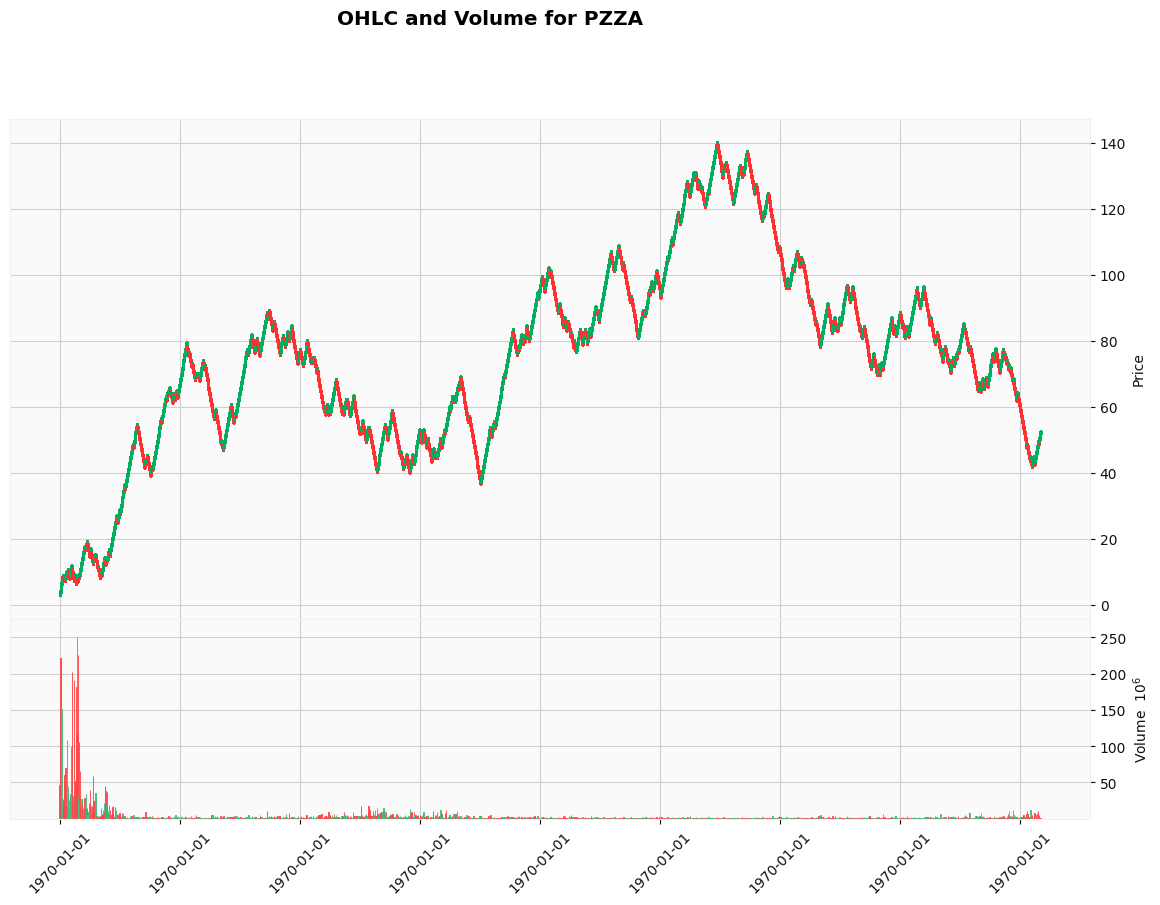

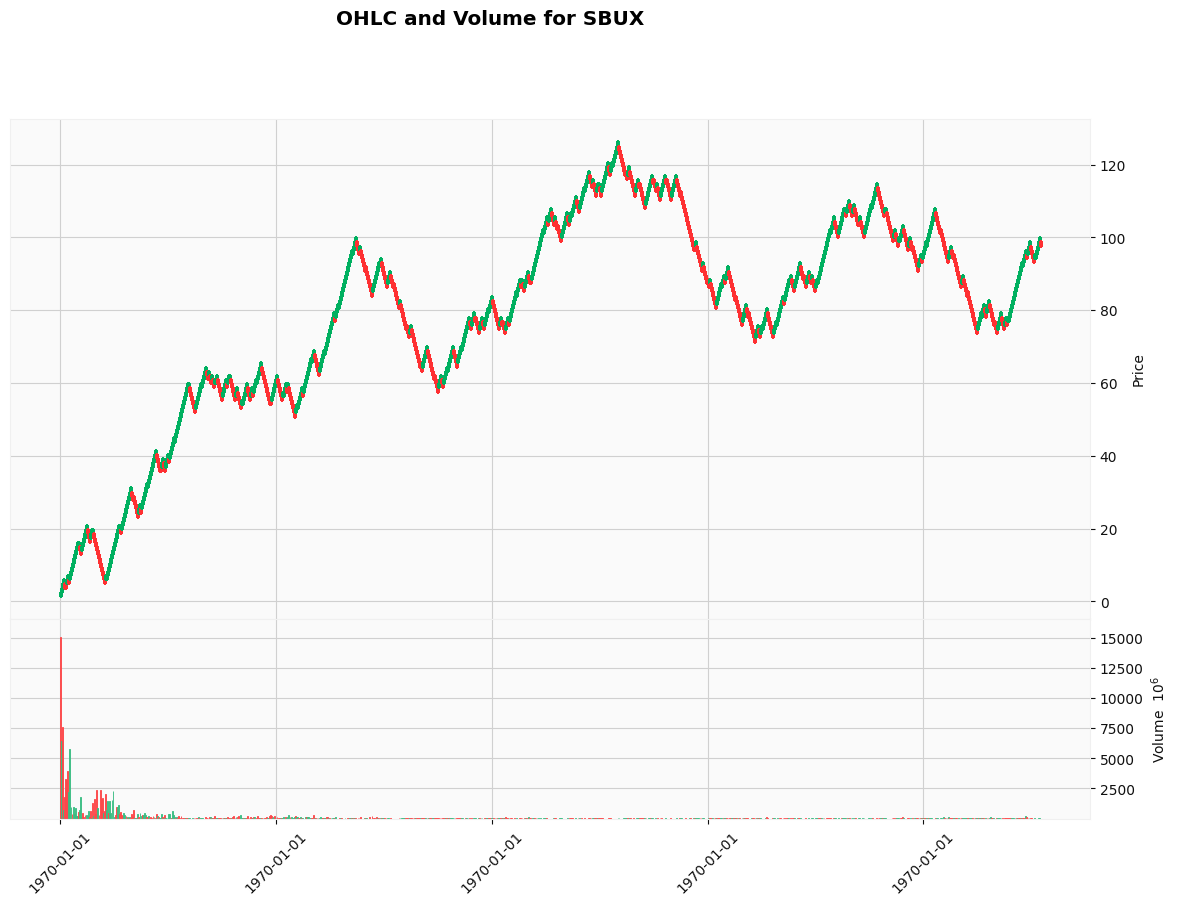

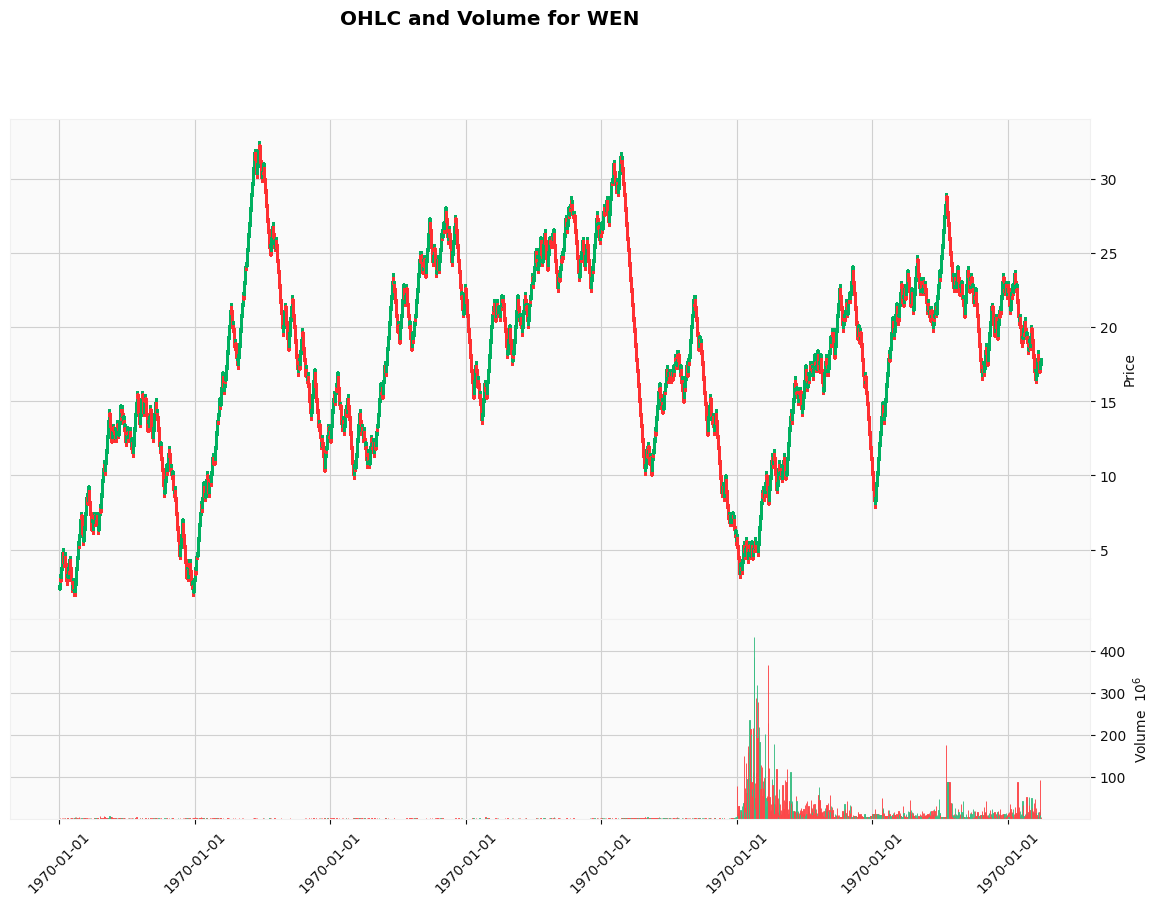

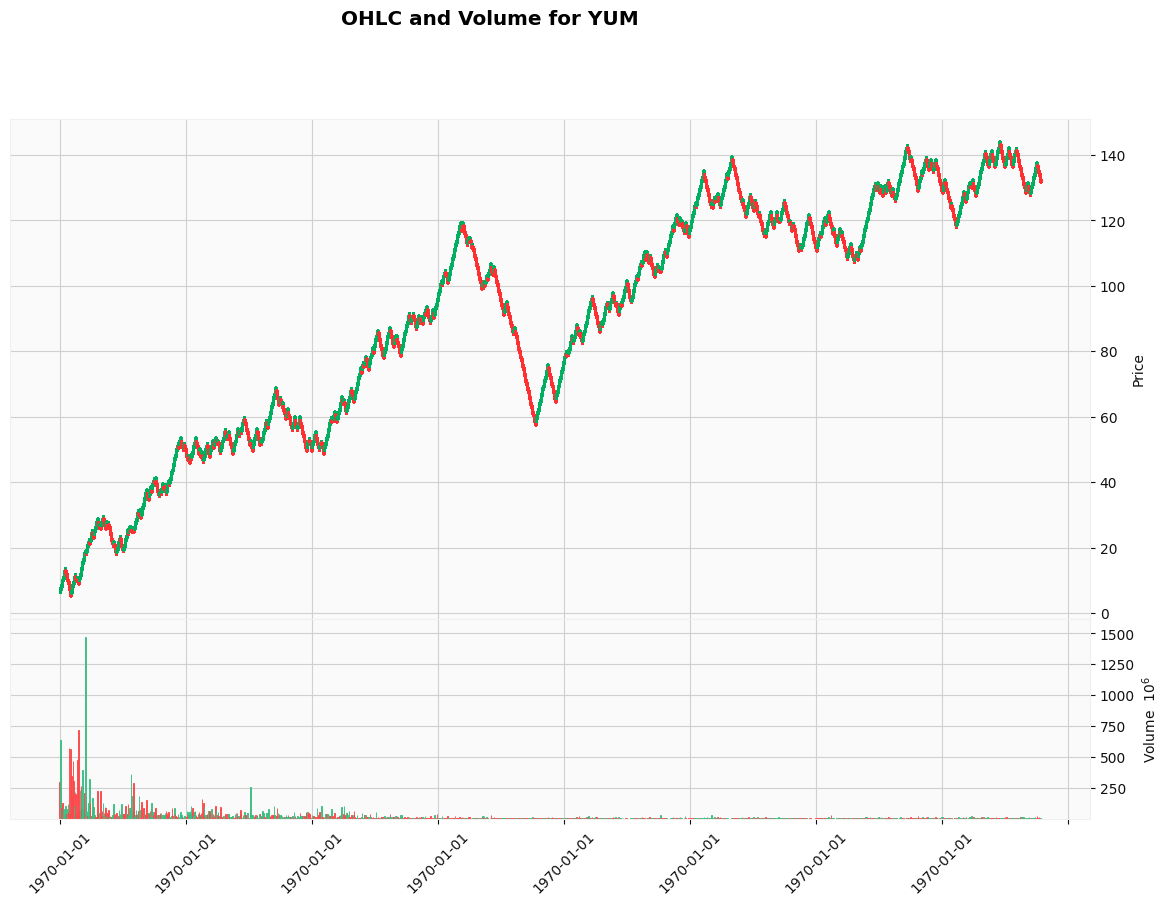

In [21]:
import mplfinance as mpf

for ticker, df in stock_data.items():
    df.index = pd.to_datetime(df.index)
    # Create dummy columns
    df['Open'] = df['Close']
    df['High'] = df['Close']
    df['Low'] = df['Close']
    renko_data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    # Plot Renko chart with volume
    mpf.plot(renko_data, type='renko', volume=True, title=f"OHLC and Volume for {ticker}",
             style='yahoo', datetime_format='%Y-%m-%d', figsize=(15, 10))

In [35]:
df.columns